# Stratification Seasonally
#### This notebook does the following:
    * takes the (density) data from the world ocean database and from the Seawolf
    * calculates the Stratification index in two ways
    * plots the mean stratification index within the NYB, MAB, and GoM monthly for each year to spot any changes in the seasonal cycle.

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile

In [2]:
# Read in the WOD data and extract month and year to new columns
df1 = pn.read_csv("~/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/WOD_CTD_format_D50_June24_2020.csv")
df1['year']=np.nan
df1['month']=np.nan
for i in range(len(df1)):
    df1.year[i] = datetime.strptime(df1.date[i], '%Y-%m-%d').year
    df1.month[i] = datetime.strptime(df1.date[i], '%Y-%m-%d').month

<ipython-input-2-42ef6c70972d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.year[i] = datetime.strptime(df1.date[i], '%Y-%m-%d').year
<ipython-input-2-42ef6c70972d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.month[i] = datetime.strptime(df1.date[i], '%Y-%m-%d').month


In [3]:
# Read in the Seawolf data and extract month and year to new columns
df2 = pn.read_csv("~/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/CTD_seawolf_AUG6.csv")
df2['year']=np.nan
df2['month']=np.nan
for i in range(len(df2)):
    df2.year[i] = datetime.strptime(df2.date[i], '%Y-%m-%d %H:%M:%S').year
    df2.month[i] = datetime.strptime(df2.date[i], '%Y-%m-%d %H:%M:%S').month

<ipython-input-3-a7b795499bda>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.year[i] = datetime.strptime(df2.date[i], '%Y-%m-%d %H:%M:%S').year
<ipython-input-3-a7b795499bda>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.month[i] = datetime.strptime(df2.date[i], '%Y-%m-%d %H:%M:%S').month


In [4]:
# Find columns in common
a = np.intersect1d(df2.columns, df1.columns)
frames = [df1, df2]

In [5]:
# Merge data into one dataframe
df3 = pn.concat([df[a] for df in frames], ignore_index=True)

### The original stratification index developed by Kurt is:

Stratification = (density at 50 meters)/1000 - (density at the surface)/1000

### An alternative stratification index:

Stratification = (density at the seafloor)/1000 - (density at the surface)/1000

In [6]:
# Create new column for original stratification index
df3['strat50'] = df3['c50_den']/1000 - df3['surf_den']/1000

In [7]:
# Create new column for alternative stratification index
df3['stratbot'] = df3['bot_den']/1000 - df3['surf_den']/1000

In [8]:
def inEPU(dataframe, shape, lon_col_name, lat_col_name, name_of_epu_as_string):
    yn = str(input("Does your dataframe have an EPU column? y/n"))
    if yn == 'y':
        print ('Great, starting inEPU')
    else:
        print ('OK, an EPU column has been added')
        dataframe['EPU'] = np.nan
    for i in range(len(dataframe)):
        if Point(dataframe[lon_col_name][i], dataframe[lat_col_name][i]).within(shape) == True:
            dataframe['EPU'][i] = name_of_epu_as_string
    return dataframe

In [9]:
def inNYB(dataframe, shape, lon_col_name, lat_col_name):
    yn = str(input("Does your dataframe have a NYB column? y/n"))
    if yn == 'y':
        print ('Great, starting inNYB')
    else:
        print ('OK, a NYB column has been added')
        dataframe['NYB'] = np.nan
    for i in range(len(dataframe)):
        if Point(dataframe[lon_col_name][i], dataframe[lat_col_name][i]).within(shape) == True:
            dataframe['NYB'][i] = 'NYB'
    return dataframe

In [10]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [11]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [12]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

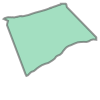

In [13]:
# Look at nyb
nyb_shape

In [14]:
# Load MAB and GoM shapefiles (already in WGS84).
# Note that this also contains shapefiles for the Scotia Shelf at index 2 and the Grand Banks at index 3.
EPU = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/EPU_NOESTUARIES.shp')

In [15]:
mab_shape = EPU.geometry[0]
gom_shape = EPU.geometry[1]

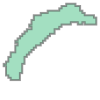

In [16]:
# Look at mab
mab_shape

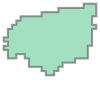

In [17]:
# Look at gom
gom_shape

In [19]:
# Identify which points are in the MAB shapefile
df3 = inEPU(df3,mab_shape,'lon','lat', 'MAB')

Does your dataframe have an EPU column? y/n n


OK, an EPU column has been added


<ipython-input-8-73e51b30538d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['EPU'][i] = name_of_epu_as_string


In [21]:
# Identify which points are in the MAB shapefile
df3 = inEPU(df3,gom_shape,'lon','lat', 'GOM')

Does your dataframe have an EPU column? y/n y


Great, starting inEPU


<ipython-input-8-73e51b30538d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['EPU'][i] = name_of_epu_as_string


In [22]:
# Identify which points are in the NYB shapefile
df3 = inNYB(df3,nyb_shape,'lon','lat')

Does your dataframe have a NYB column? y/n n


OK, a NYB column has been added


<ipython-input-9-ff8895e12bd9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['NYB'][i] = 'NYB'


# Plots for NYB

In [23]:
# Remove rows outside of NYB
nyb_df = df3[df3.NYB == 'NYB']

In [24]:
# Find the years for the data
unique_years  = np.unique(nyb_df.year)

In [25]:
np.where(unique_years==2010)

(array([33]),)

In [26]:
# Creates matricies of monthoy means the data by year
monthly_50 = np.empty([len(unique_years),12])
monthly_bot = np.empty([len(unique_years),12])

k=0
for i in (unique_years):
    year_picked = nyb_df[nyb_df.year == i]
    for j in range(12):
        if any(year_picked.month == float(j+1)):
            month_picked = year_picked[(year_picked.month == float(j+1))]
            if len(month_picked)<3: # Sets the minimum number of datapoints to 3 (you can pick)
                monthly_50[k,j] = np.nan
                monthly_bot[k,j] = np.nan
            else:
                monthly_50[k,j] = np.nanmean(month_picked.strat50)
                monthly_bot[k,j] = np.nanmean(month_picked.stratbot)
        else:
            monthly_50[k,j] = np.nan
            monthly_bot[k,j] = np.nan
    k = k+1

<ipython-input-26-edc653d12333>:15: RuntimeWarning: Mean of empty slice
  monthly_50[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-26-edc653d12333>:16: RuntimeWarning: Mean of empty slice
  monthly_bot[k,j] = np.nanmean(month_picked.stratbot)


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'NYB')

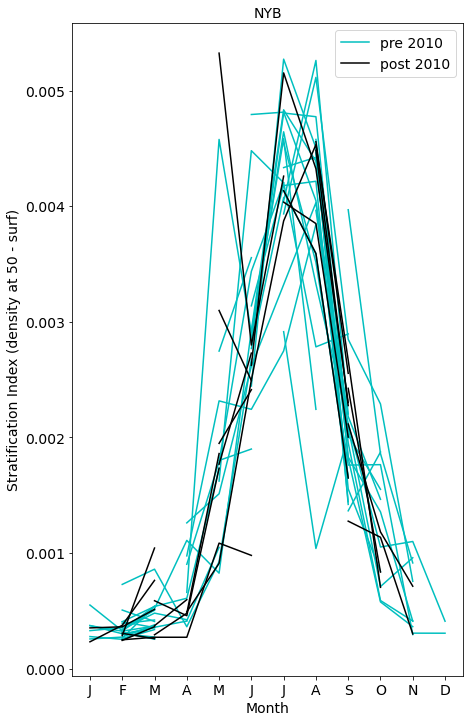

In [272]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_50[0,:],color = 'c', label = 'pre 2010')

for i in range(0,33):
    ax.plot(np.arange(0,12),monthly_50[i,:],color = 'c',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_50[27,:],color = 'k', label = 'post 2010')
for i in range(33,44):
    ax.plot(np.arange(0,12),monthly_50[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
plt.title('NYB', fontsize = 14)
#ax.set_ylim([15,20])

#ax.ymax(20)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


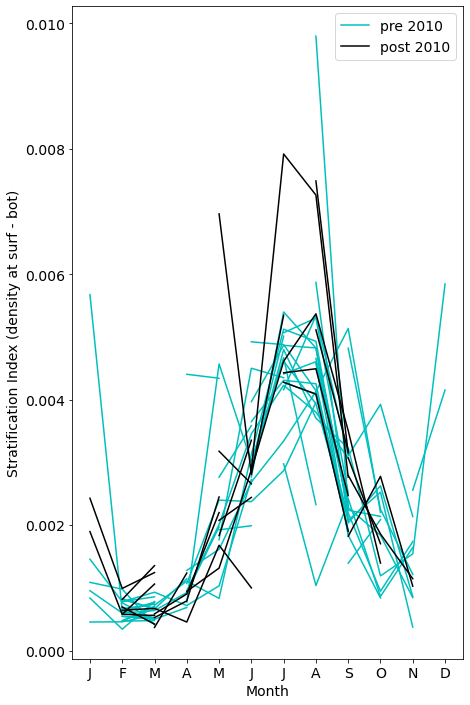

In [273]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_bot[0,:],color = 'c', label = 'pre 2010')

for i in range(0,33):
    ax.plot(np.arange(0,12),monthly_bot[i,:],color = 'c',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_bot[27,:],color = 'k', label = 'post 2010')
for i in range(33,44):
    ax.plot(np.arange(0,12),monthly_bot[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at bot - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])

#ax.ymax(20)

In [96]:
nyb_df[nyb_df['year']==1961] # No stratification data from 1961, it will not be included

,Unnamed: 0,bot_den,bot_depth,bot_sal,bot_temp,c50_den,c50_depth,c50_sal,c50_temp,date,...,lon,month,surf_den,surf_sal,surf_temp,year,strat50,stratbot,EPU,NYB
0,1,NaN,NaN,NaN,3.7,NaN,31.200001,NaN,3.7,1961-01-20,...,-71.599998,1.0,NaN,NaN,3.7,1961.0,NaN,NaN,MAB,NYB


In [156]:
import warnings
warnings.filterwarnings("once")

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-153-1804b636234f>:4: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
<ipython-input-157-ee79f4a644e6>:15: RuntimeWarning: Mean of empty slice
  month_plot[2,i] = np.nanmean(month_sub_df['strat50'])
<ipython-input-157-ee79f4a644e6>:15: RuntimeWarning: Mean of empty slice
  month_plot[2,i] = np.nanmean(month_sub_df['strat50'])
<ipython-input-157-ee79f4a644e6>:15: RuntimeWarning: Mean of empty slice
  month_plot[2,i] = np.nanmean(month_sub_df['strat50'])
<ipython-input-157-ee79f4a644e6>:15: RuntimeWarning: Mean of empty slice
  month_plot[2,i] = np.nanmean(month_sub_df['

(0.0, 0.01)

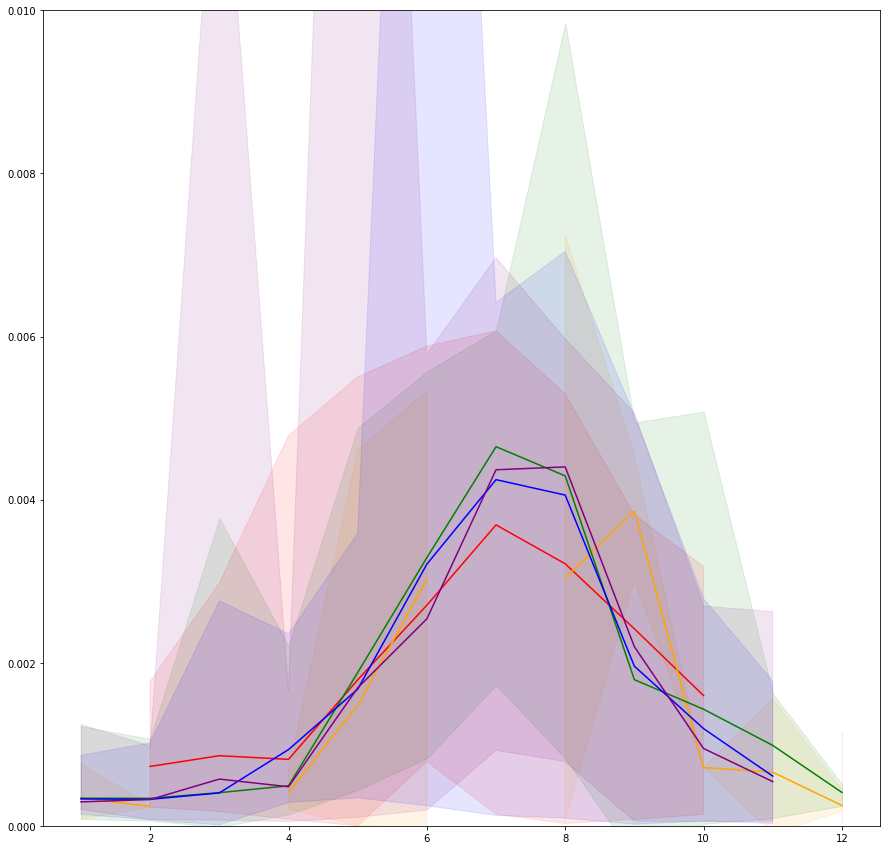

In [157]:
fxn()
start_year = [1970,1980,1990,2000,2010]
colors = ['red', 'orange', 'green', 'blue', 'purple']

fig = plt.subplots(figsize = [15,15])
for j in range(5):
    sub_df = nyb_df[(nyb_df['year']>=start_year[j]) & (nyb_df['year']<start_year[j]+10)]
    month_plot = np.empty([3,12])
    month_plot[:,:] = np.nan
    for i in range(12):
        month_sub_df = sub_df[sub_df['month']==i+1]
        if any(month_sub_df) == True:
            month_plot[0,i] = np.min(month_sub_df['strat50'])
            month_plot[1,i] = np.max(month_sub_df['strat50'])
            month_plot[2,i] = np.nanmean(month_sub_df['strat50'])
    plt.plot(np.arange(1,13),month_plot[2,:],c = colors[j])
    plt.fill_between(np.arange(1,13), month_plot[0,:], month_plot[1,:],
                 facecolor= colors[j], # The fill color
                 color=colors[j],       # The outline color
                 alpha=0.1)          # Transparency of the fill

plt.ylim([0,0.010])
# Data
#x =  [0,1,2,3,4,5,6,7,8,9]
#y1 = [10,20,40,55,58,55,50,40,20,10]
#y2 = [20,30,50,77,82,77,75,68,65,60]

# Shade the area between y1 and y2


<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-150-54f187a51339>:17: RuntimeWarning: Mean of empty slice
  month_pl

(0.0, 0.007)

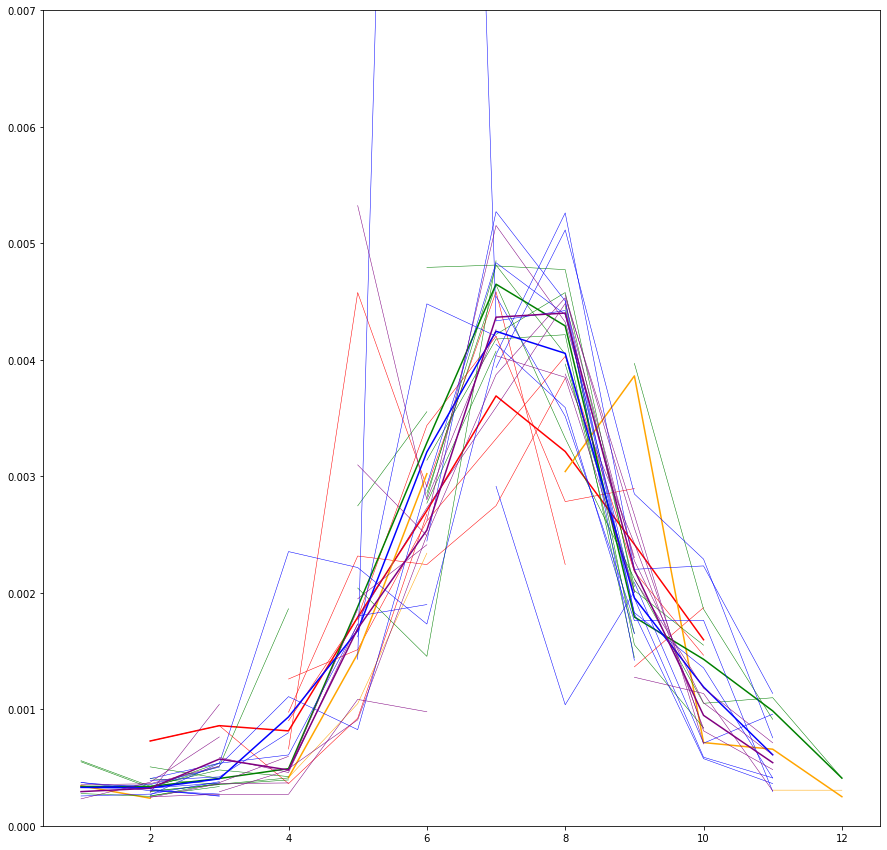

In [150]:
start_year = [1970,1980,1990,2000,2010]
colors = ['red', 'orange', 'green', 'blue', 'purple']

fig = plt.subplots(figsize = [15,15])
for j in range(5):
    sub_df = nyb_df[(nyb_df['year']>=start_year[j]) & (nyb_df['year']<start_year[j]+10)]
    sub_years = np.unique(sub_df['year'])
    month_plot = np.empty([12])
    month_plot[:] = np.nan
    for i in range(len(sub_years)):
        sub_df_yr = sub_df[sub_df['year']==sub_years[i]]
        month_plot_yr = np.empty([12])
        month_plot_yr[:] = np.nan
        for i in range(12):
            month_sub_df_yr = sub_df_yr[sub_df_yr['month']==i+1]
            if any(month_sub_df_yr) == True:
                month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
        plt.plot(np.arange(1,13),month_plot_yr, c = colors[j], linewidth = 0.5)
    for i in range(12):
        month_sub_df = sub_df[sub_df['month']==i+1]
        if any(month_sub_df) == True:
            month_plot[i] = np.nanmean(month_sub_df['strat50'])
    plt.plot(np.arange(1,13),month_plot[:],c = colors[j])
plt.ylim([0,0.007])
# Data
#x =  [0,1,2,3,4,5,6,7,8,9]
#y1 = [10,20,40,55,58,55,50,40,20,10]
#y2 = [20,30,50,77,82,77,75,68,65,60]

# Shade the area between y1 and y2


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-282-58f9358c3081>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-282-58f9358c3081>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-282-58f9358c3081>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-282-58f9358c3081>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-282-58f9358c3081>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month

Text(0.5, 1.0, 'NYB')

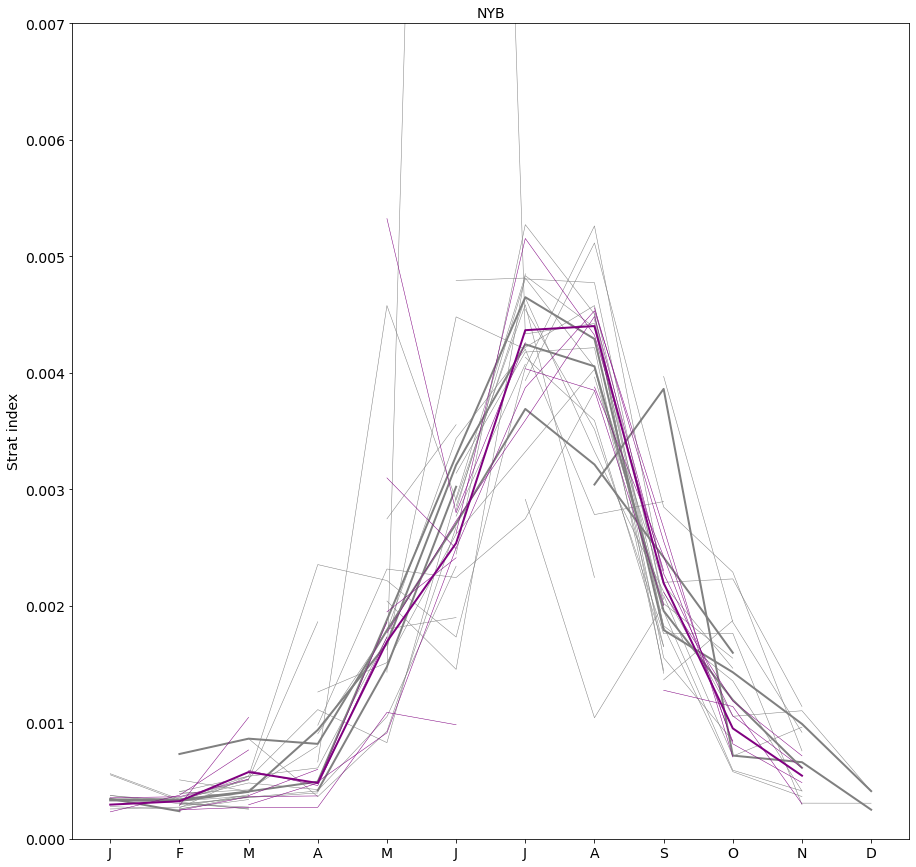

In [282]:
start_year = [1970,1980,1990,2000,2010]
colors = ['grey', 'grey', 'grey', 'grey', 'purple']
#linestyles = ['--','-.','densely dashdotdotted','densely dashed', '-' ]
fig = plt.subplots(figsize = [15,15])
for j in range(5):
    sub_df = nyb_df[(nyb_df['year']>=start_year[j]) & (nyb_df['year']<start_year[j]+10)]
    sub_years = np.unique(sub_df['year'])
    month_plot = np.empty([12])
    month_plot[:] = np.nan
    for i in range(len(sub_years)):
        sub_df_yr = sub_df[sub_df['year']==sub_years[i]]
        month_plot_yr = np.empty([12])
        month_plot_yr[:] = np.nan
        for i in range(12):
            month_sub_df_yr = sub_df_yr[sub_df_yr['month']==i+1]
            if any(month_sub_df_yr) == True:
                month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
        plt.plot(np.arange(1,13),month_plot_yr, c = colors[j], linewidth = 0.5)
    for i in range(12):
        month_sub_df = sub_df[sub_df['month']==i+1]
        if any(month_sub_df) == True:
            month_plot[i] = np.nanmean(month_sub_df['strat50'])
    plt.plot(np.arange(1,13),month_plot[:],c = colors[j],linewidth = 2)
plt.ylim([0,0.007])
plt.tick_params(labelsize = 14)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], labels = ['J','F','M','A','M','J','J','A','S','O','N','D'])
#plt.xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
plt.ylabel('Strat index', fontsize = 14)
plt.title('NYB', fontsize = 14)

In [144]:
j=0
sub_df = nyb_df[(nyb_df['year']>=start_year[j]) & (nyb_df['year']<start_year[j]+10)]
np.unique(sub_df['year'])

array([1975., 1976., 1977., 1978., 1979.])

In [132]:
month_plot = np.empty([3,12])
month_plot[:,:] = np.nan
month_plot

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [ ]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_bot[0,:],color = 'g', label = 'pre 2010')

for i in range(0,33):
    ax.plot(np.arange(0,12),monthly_bot[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_bot[27,:],color = 'k', label = 'post 2010')
for i in range(33,44):
    ax.plot(np.arange(0,12),monthly_bot[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])

#ax.ymax(20)

<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
<ipython-input-38-22fedb7ae512>:8: RuntimeWarning: Mean of empty slice
  mean_yearnyb[k] = np.nanmean(subset_year['str

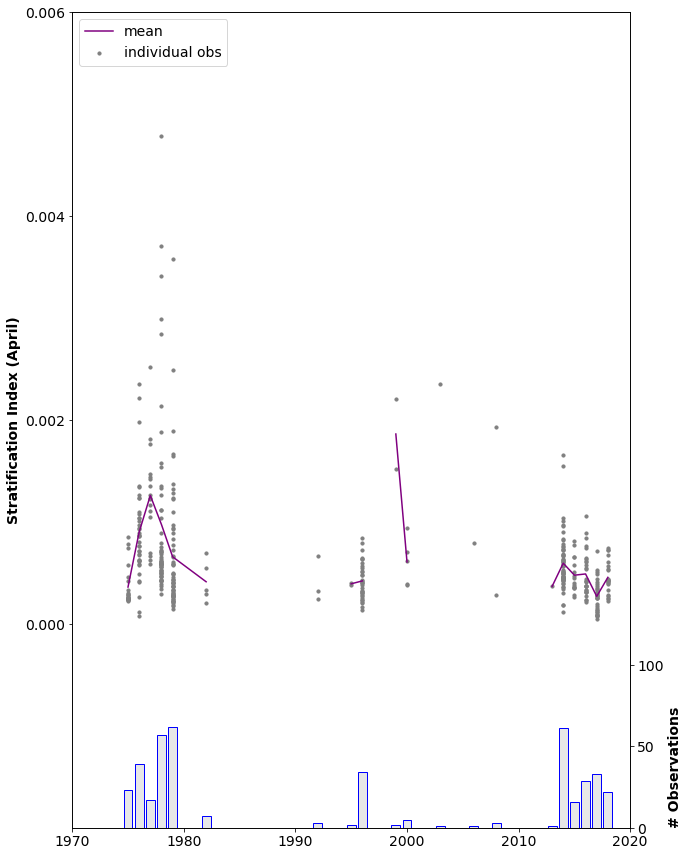

In [38]:
k=0
mean_yearnyb =np.empty(len(unique_years))
nobs = np.empty(len(unique_years))

fig,ax = plt.subplots(figsize = [10,15])
for i in unique_years:
    subset_year = nybApril[nybApril['year']==i]
    mean_yearnyb[k] = np.nanmean(subset_year['strat50'])
    nobs[k] = len(subset_year)
    if i == unique_years[0]:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = 'individual obs')
    else:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = '')
    k=k+1
ax.set_xlim([1970,2020])
ax.tick_params(axis = 'x', labelsize = 14)
ax2 = ax.twinx()
ax2.bar(unique_years, nobs,color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.plot(unique_years,mean_yearnyb,c='purple',label = 'mean')
ax.set_ylim([-0.002,0.006])
ax2.set_ylim([0,500])
ax.set_yticks(np.arange(0,0.008,0.002))
ax.tick_params(axis = 'y', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)
ax2.set_yticks(np.arange(0,150,50))

ax.set_ylabel('Stratification Index (April)', fontweight = 'bold',fontsize = 14)
ax2.set_ylabel('# Observations', fontsize = 14, fontweight = 'bold', loc = 'bottom')
ax.legend(fontsize = 14, loc = 'upper left')

# Plots for MAB

In [66]:
# Remove rows outside of NYB
mab_df = df3[df3.EPU == 'MAB']

In [67]:
# Find the years for the data
unique_yearsmab  = np.unique(mab_df.year)

In [78]:
np.where(unique_yearsmab==2010)

(array([33]),)

In [80]:
len(unique_yearsmab)

44

In [68]:
# Creates matricies of monthoy means the data by year
monthly_50mab = np.empty([len(unique_yearsmab),12])
monthly_botmab = np.empty([len(unique_yearsmab),12])

k=0
for i in (unique_yearsmab):
    year_picked = mab_df[mab_df.year == i]
    for j in range(12):
        if any(year_picked.month == float(j+1)):
            month_picked = year_picked[(year_picked.month == float(j+1))]
            if len(month_picked)<3: # Sets the minimum number of datapoints to 3 (you can pick)
                monthly_50mab[k,j] = np.nan
                monthly_botmab[k,j] = np.nan
            else:
                monthly_50mab[k,j] = np.nanmean(month_picked.strat50)
                monthly_botmab[k,j] = np.nanmean(month_picked.stratbot)
        else:
            monthly_50mab[k,j] = np.nan
            monthly_botmab[k,j] = np.nan
    k = k+1

<ipython-input-68-e78f8474c3ce>:15: RuntimeWarning: Mean of empty slice
  monthly_50mab[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-68-e78f8474c3ce>:16: RuntimeWarning: Mean of empty slice
  monthly_botmab[k,j] = np.nanmean(month_picked.stratbot)
<ipython-input-68-e78f8474c3ce>:15: RuntimeWarning: Mean of empty slice
  monthly_50mab[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-68-e78f8474c3ce>:16: RuntimeWarning: Mean of empty slice
  monthly_botmab[k,j] = np.nanmean(month_picked.stratbot)


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MAB')

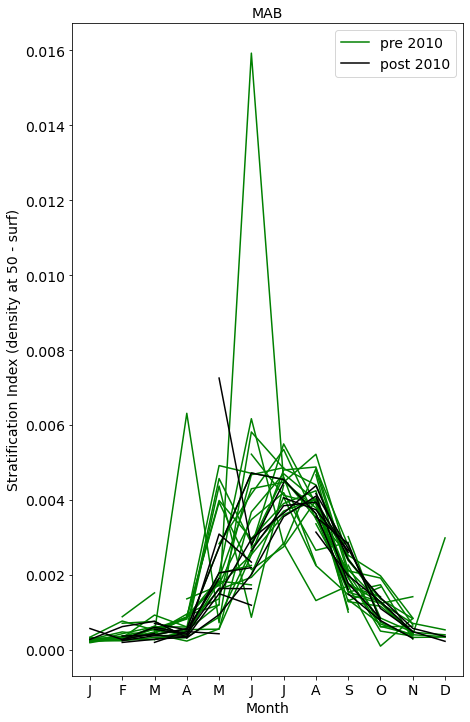

In [284]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_50mab[0,:],color = 'g', label = 'pre 2010')

for i in range(0,33):
    ax.plot(np.arange(0,12),monthly_50mab[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_50mab[27,:],color = 'k', label = 'post 2010')
for i in range(33,44):
    ax.plot(np.arange(0,12),monthly_50mab[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])
ax.set_title ('MAB', fontsize = 14)
#ax.ymax(20)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MAB')

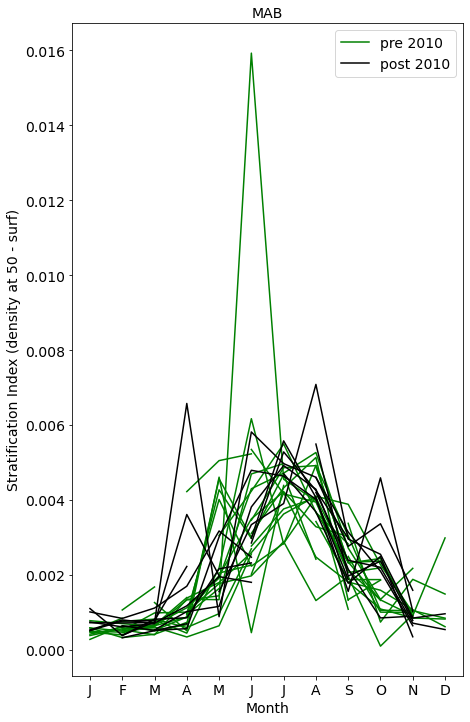

In [285]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_botmab[0,:],color = 'g', label = 'pre 2010')

for i in range(0,27):
    ax.plot(np.arange(0,12),monthly_botmab[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_botmab[27,:],color = 'k', label = 'post 2010')
for i in range(28,37):
    ax.plot(np.arange(0,12),monthly_botmab[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title ('MAB', fontsize = 14)
#ax.set_ylim([15,20])

#ax.ymax(20)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-158-f0d5ce3b0298>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-158-f0d5ce3b0298>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-158-f0d5ce3b0298>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-158-f0d5ce3b0298>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-158-f0d5ce3b0298>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month

(0.0, 0.007)

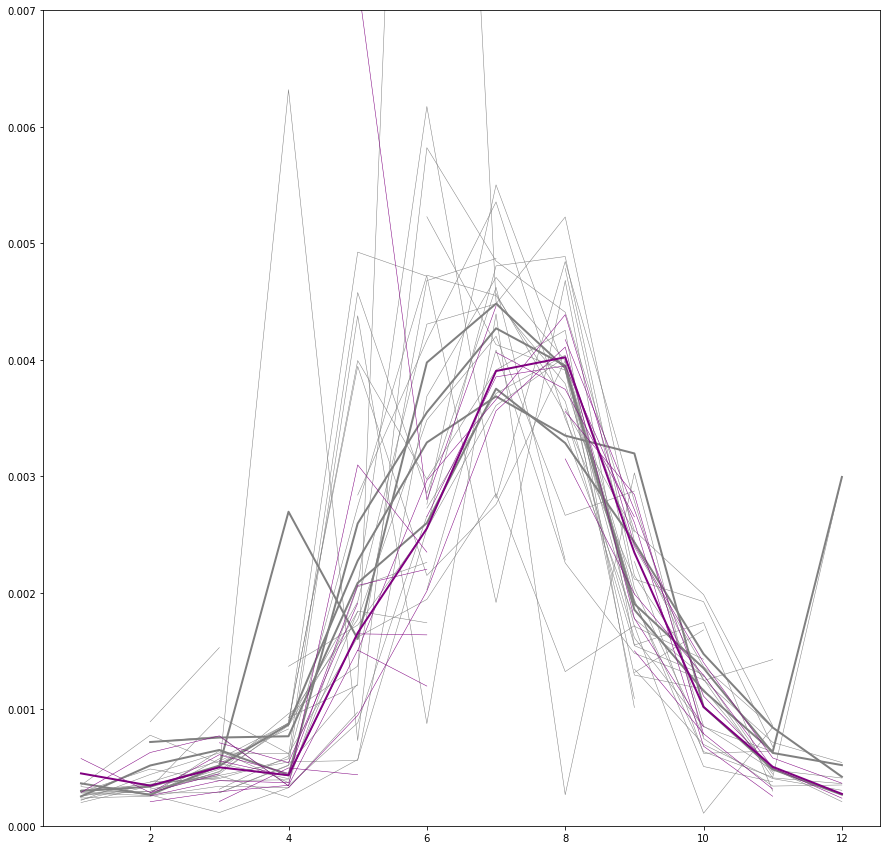

In [158]:
start_year = [1970,1980,1990,2000,2010]
colors = ['grey', 'grey', 'grey', 'grey', 'purple']

fig = plt.subplots(figsize = [15,15])
for j in range(5):
    sub_df = mab_df[(mab_df['year']>=start_year[j]) & (mab_df['year']<start_year[j]+10)]
    sub_years = np.unique(sub_df['year'])
    month_plot = np.empty([12])
    month_plot[:] = np.nan
    for i in range(len(sub_years)):
        sub_df_yr = sub_df[sub_df['year']==sub_years[i]]
        month_plot_yr = np.empty([12])
        month_plot_yr[:] = np.nan
        for i in range(12):
            month_sub_df_yr = sub_df_yr[sub_df_yr['month']==i+1]
            if any(month_sub_df_yr) == True:
                month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
        plt.plot(np.arange(1,13),month_plot_yr, c = colors[j], linewidth = 0.5)
    for i in range(12):
        month_sub_df = sub_df[sub_df['month']==i+1]
        if any(month_sub_df) == True:
            month_plot[i] = np.nanmean(month_sub_df['strat50'])
    plt.plot(np.arange(1,13),month_plot[:],c = colors[j],linewidth = 2)
plt.ylim([0,0.007])

In [ ]:
k=0
mean_yearmab =np.empty(len(unique_years))
nobs = np.empty(len(unique_years))

fig,ax = plt.subplots(figsize = [10,15])
for i in unique_years:
    subset_year = mabApril[mabApril['year']==i]
    mean_yearmab[k] = np.nanmean(subset_year['strat50'])
    nobs[k] = len(subset_year)
    if i == unique_years[0]:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = 'individual obs')
    else:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = '')
    k=k+1
ax.set_xlim([1970,2020])
ax.tick_params(axis = 'x', labelsize = 14)
ax2 = ax.twinx()
ax2.bar(unique_years, nobs,color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.plot(unique_years,mean_yearmab,c='purple',label = 'mean')
ax.set_ylim([-0.002,0.012])
ax2.set_ylim([0,1000])
ax.set_yticks(np.arange(0,0.014,0.002))
ax.tick_params(axis = 'y', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)
ax2.set_yticks(np.arange(0,200,50))

ax.set_ylabel('Stratification Index (50m)', fontweight = 'bold',fontsize = 14)
ax2.set_ylabel('# Observations', fontsize = 14, fontweight = 'bold', loc = 'bottom')
ax.legend(fontsize = 14, loc = 'upper left')

# Plots for GoM

In [159]:
# Remove rows outside of NYB
gom_df = df3[df3.EPU == 'GOM']

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
# Find the years for the data
unique_yearsgom  = np.unique(gom_df.year)[:49]

In [162]:
# Creates matricies of monthoy means the data by year
monthly_50gom = np.empty([len(unique_yearsmab),12])
monthly_botgom = np.empty([len(unique_yearsmab),12])

k=0
for i in (unique_yearsmab):
    year_picked = gom_df[gom_df.year == i]
    for j in range(12):
        if any(year_picked.month == float(j+1)):
            month_picked = year_picked[(year_picked.month == float(j+1))]
            if len(month_picked)<3: # Sets the minimum number of datapoints to 3 (you can pick)
                monthly_50gom[k,j] = np.nan
                monthly_botgom[k,j] = np.nan
            else:
                monthly_50gom[k,j] = np.nanmean(month_picked.strat50)
                monthly_botgom[k,j] = np.nanmean(month_picked.stratbot)
        else:
            monthly_50gom[k,j] = np.nan
            monthly_botgom[k,j] = np.nan
    k = k+1

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-162-15858b626667>:15: RuntimeWarning: Mean of empty slice
  monthly_50gom[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-162-15858b626667>:15: RuntimeWarning: Mean of empty slice
  monthly_50gom[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-162-15858b626667>:15: RuntimeWarning: Mean of empty slice
  monthly_50gom[k,j] = np.nanmean(month_picked.strat50)
<ipython-input-162-15858b626667>:16: RuntimeWarning: Mean of empty slice
  monthly_botgom[k,j] = np.nanmean(month_picked.stratbot)


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'GOM')

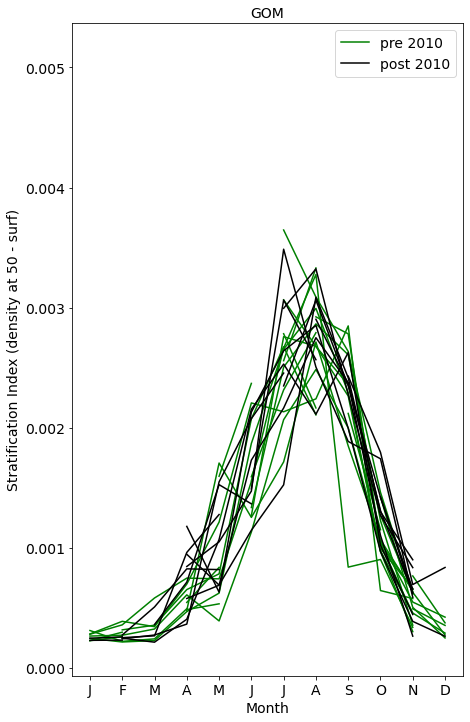

In [286]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_50gom[0,:],color = 'g', label = 'pre 2010')

for i in range(0,27):
    ax.plot(np.arange(0,12),monthly_50gom[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_50gom[27,:],color = 'k', label = 'post 2010')
for i in range(28,37):
    ax.plot(np.arange(0,12),monthly_50gom[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])
ax.set_title('GOM', fontsize = 14)
#ax.ymax(20)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'GOM')

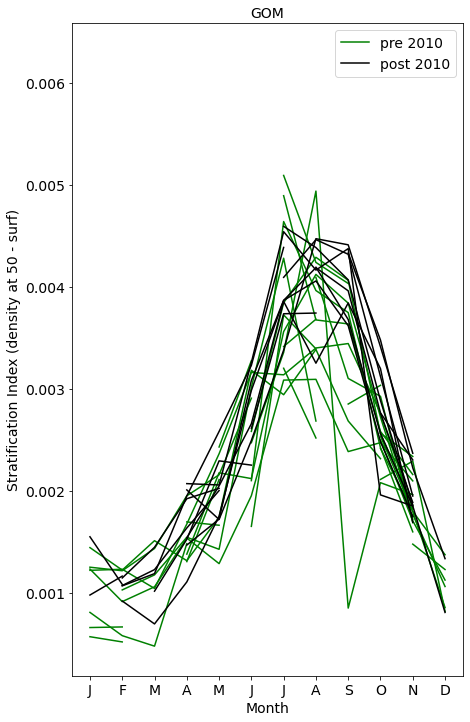

In [287]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly_botgom[0,:],color = 'g', label = 'pre 2010')

for i in range(0,27):
    ax.plot(np.arange(0,12),monthly_botgom[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly_botgom[27,:],color = 'k', label = 'post 2010')
for i in range(28,37):
    ax.plot(np.arange(0,12),monthly_botgom[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Stratification Index (density at 50 - surf)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])
ax.set_title('GOM', fontsize = 14)
#ax.ymax(20)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-165-3c24ea9ddb57>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-165-3c24ea9ddb57>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-165-3c24ea9ddb57>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-165-3c24ea9ddb57>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
<ipython-input-165-3c24ea9ddb57>:17: RuntimeWarning: Mean of empty slice
  month_plot_yr[i]=np.nanmean(month

(0.0, 0.007)

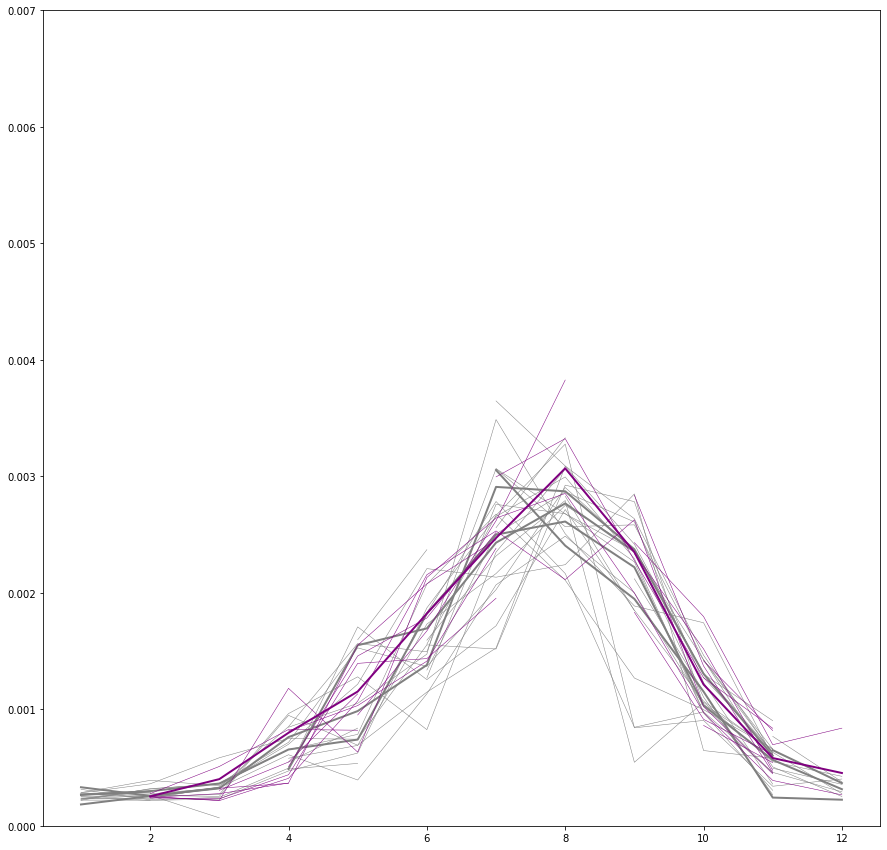

In [165]:
start_year = [1970,1980,1990,2000,2010]
colors = ['grey', 'grey', 'grey', 'grey', 'purple']

fig = plt.subplots(figsize = [15,15])
for j in range(5):
    sub_df = gom_df[(gom_df['year']>=start_year[j]) & (gom_df['year']<start_year[j]+10)]
    sub_years = np.unique(sub_df['year'])
    month_plot = np.empty([12])
    month_plot[:] = np.nan
    for i in range(len(sub_years)):
        sub_df_yr = sub_df[sub_df['year']==sub_years[i]]
        month_plot_yr = np.empty([12])
        month_plot_yr[:] = np.nan
        for i in range(12):
            month_sub_df_yr = sub_df_yr[sub_df_yr['month']==i+1]
            if any(month_sub_df_yr) == True:
                month_plot_yr[i]=np.nanmean(month_sub_df_yr['strat50'])
        plt.plot(np.arange(1,13),month_plot_yr, c = colors[j], linewidth = 0.5)
    for i in range(12):
        month_sub_df = sub_df[sub_df['month']==i+1]
        if any(month_sub_df) == True:
            month_plot[i] = np.nanmean(month_sub_df['strat50'])
    plt.plot(np.arange(1,13),month_plot[:],c = colors[j],linewidth = 2)
plt.ylim([0,0.007])

# See if something is happening in April across all years

In [27]:
nybApril = nyb_df[nyb_df['month']==4]
nybApril

,Unnamed: 0,bot_den,bot_depth,bot_sal,bot_temp,c50_den,c50_depth,c50_sal,c50_temp,date,...,lon,month,surf_den,surf_sal,surf_temp,year,strat50,stratbot,EPU,NYB
166,167,1027.996901,666.0,35.389999,11.02,1026.863102,50.00000,34.189999,8.02,1975-04-09,...,-72.425003,4.0,1026.606062,34.139999,8.01,1975.0,0.000257,0.001391,MAB,NYB
167,168,1027.307477,103.0,34.990002,10.53,1026.795150,50.00000,34.060001,7.79,1975-04-10,...,-72.760002,4.0,1026.572689,34.060001,7.81,1975.0,0.000222,0.000735,MAB,NYB
168,169,1026.882459,70.0,34.070000,7.84,1026.797116,50.00000,34.070000,7.83,1975-04-10,...,-73.006668,4.0,1026.558434,34.040001,7.80,1975.0,0.000239,0.000324,MAB,NYB
169,170,1026.756829,64.0,33.860001,7.25,1026.719785,50.00000,33.860001,7.22,1975-04-10,...,-73.233330,4.0,1026.473658,33.820000,7.18,1975.0,0.000246,0.000283,MAB,NYB
175,176,1026.606149,60.0,33.500000,6.30,1026.493707,50.00000,33.250000,5.23,1975-04-10,...,-73.711670,4.0,1025.751175,32.639999,5.59,1975.0,0.000743,0.000855,MAB,NYB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77999,78000,1026.344000,62.0,33.143000,6.06,1026.307000,49.60978,33.143000,6.06,2018-04-18,...,-72.211670,4.0,1025.879000,32.888000,6.08,2018.0,0.000428,0.000465,MAB,NYB
78000,78001,1026.390000,68.0,33.181000,6.11,1026.317000,49.61000,33.160000,6.09,2018-04-18,...,-72.150000,4.0,1025.880000,32.895000,6.19,2018.0,0.000437,0.000510,MAB,NYB
78001,78002,1028.099000,222.0,35.385000,10.67,1026.932000,49.61134,35.108000,11.81,2018-04-18,...,-71.595000,4.0,1026.186000,33.548000,7.70,2018.0,0.000746,0.001913,MAB,NYB
78002,78003,1027.964000,205.0,35.483000,11.49,1026.925000,49.61116,35.109000,11.85,2018-04-19,...,-71.470000,4.0,1026.253000,33.734000,8.24,2018.0,0.000672,0.001711,MAB,NYB


<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-28-806e687d7928>:5: RuntimeWarning: Mean of empty slice
  mean_year[k] = np.nanmean(subset_year['strat50'])
<ipython-input-2

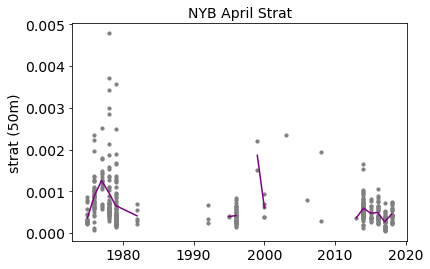

In [28]:
k=0
mean_year =np.empty(len(unique_years))
for i in unique_years:
    subset_year = nybApril[nybApril['year']==i]
    mean_year[k] = np.nanmean(subset_year['strat50'])
    plt.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey')
    k=k+1
plt.plot(unique_years,mean_year,c='purple')
plt.title('NYB April Strat', fontsize = 14)
plt.ylabel('strat (50m)',fontsize = 14)
plt.tick_params(labelsize = 14)

In [178]:
unique_years

array([1961., 1975., 1976., 1977., 1978., 1979., 1982., 1983., 1984.,
       1985., 1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.])

In [179]:
mean_year

array([       nan, 0.00036198, 0.00090208, 0.0012602 , 0.00097483,
       0.00065875, 0.00041403,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.00041071,        nan,        nan, 0.00039382, 0.00042246,
              nan,        nan, 0.00186349, 0.00060835,        nan,
              nan, 0.002354  ,        nan,        nan, 0.000799  ,
              nan, 0.001109  ,        nan,        nan,        nan,
              nan, 0.000368  , 0.00059598, 0.0004785 , 0.00049052,
       0.00027064, 0.00045727,        nan,        nan])

In [225]:
mabApril = mab_df[mab_df['month']==4]
gomApril = gom_df[gom_df['month']==4]


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-223-9c8081ccf5ee>:8: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-223-9c8081ccf5ee>:8: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-223-9c8081ccf5ee>:8: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-223-9c8081ccf5ee>:8: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-223-9c8081ccf5ee>:8: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'

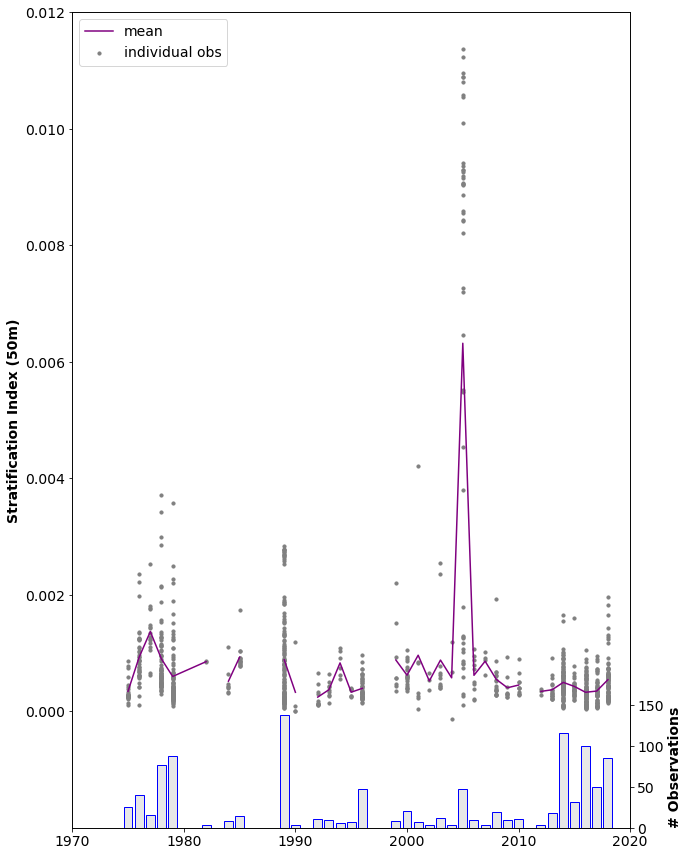

In [223]:
k=0
mean_yearmab =np.empty(len(unique_years))
nobs = np.empty(len(unique_years))

fig,ax = plt.subplots(figsize = [10,15])
for i in unique_years:
    subset_year = mabApril[mabApril['year']==i]
    mean_yearmab[k] = np.nanmean(subset_year['strat50'])
    nobs[k] = len(subset_year)
    if i == unique_years[0]:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = 'individual obs')
    else:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'grey', label = '')
    k=k+1
ax.set_xlim([1970,2020])
ax.tick_params(axis = 'x', labelsize = 14)
ax2 = ax.twinx()
ax2.bar(unique_years, nobs,color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.plot(unique_years,mean_yearmab,c='purple',label = 'mean')
ax.set_ylim([-0.002,0.012])
ax2.set_ylim([0,1000])
ax.set_yticks(np.arange(0,0.014,0.002))
ax.tick_params(axis = 'y', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)
ax2.set_yticks(np.arange(0,200,50))

ax.set_ylabel('Stratification Index (50m)', fontweight = 'bold',fontsize = 14)
ax2.set_ylabel('# Observations', fontsize = 14, fontweight = 'bold', loc = 'bottom')
ax.legend(fontsize = 14, loc = 'upper left')

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-269-ac5985ea0649>:10: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-269-ac5985ea0649>:10: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-269-ac5985ea0649>:10: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-269-ac5985ea0649>:10: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['strat50'])
<ipython-input-269-ac5985ea0649>:10: RuntimeWarning: Mean of empty slice
  mean_yearmab[k] = np.nanmean(subset_year['str

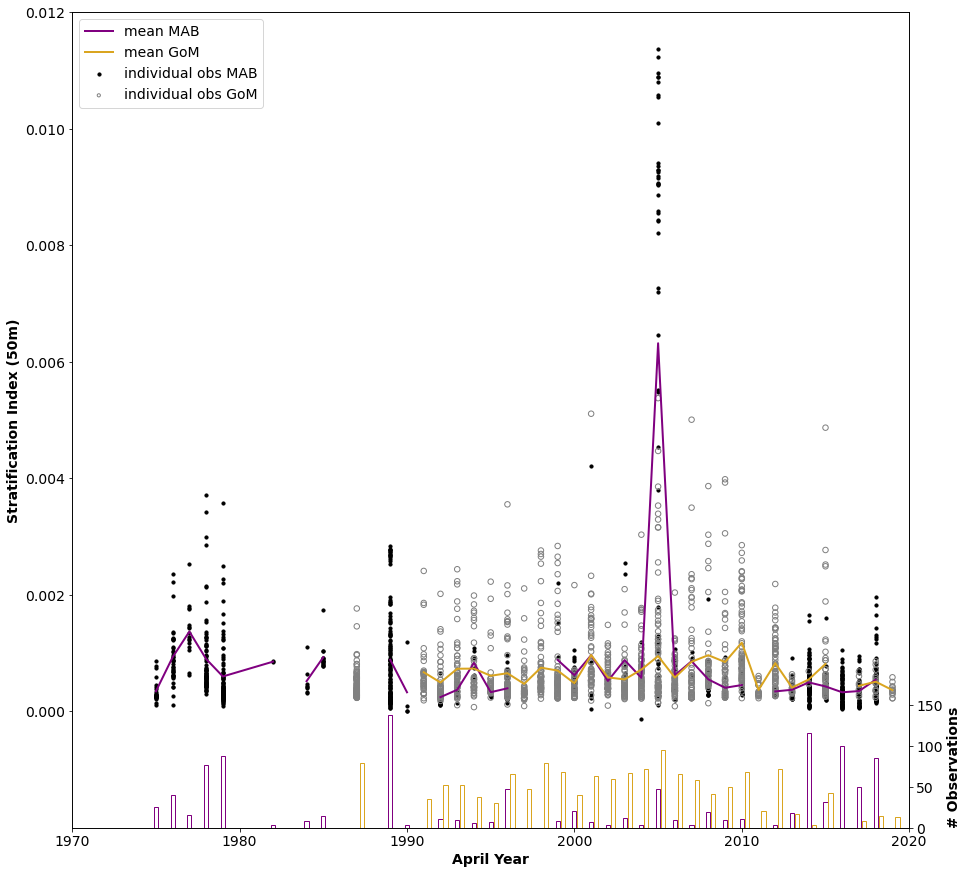

In [269]:
k=0
mean_yearmab =np.empty(len(unique_yearsmab))
mean_yeargom =np.empty(len(unique_yearsgom))
nobsmab = np.empty(len(unique_yearsmab))
nobsgom = np.empty(len(unique_yearsgom))

fig,ax = plt.subplots(figsize = [15,15])
for i in unique_yearsmab:
    subset_year = mabApril[mabApril['year']==i]
    mean_yearmab[k] = np.nanmean(subset_year['strat50'])
    nobsmab[k] = len(subset_year)
    if i == unique_yearsmab[0]:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'k', label = 'individual obs MAB')
    else:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'k', label = '')
    k=k+1

k=0
for i in unique_yearsgom:
    subset_year = gomApril[gomApril['year']==i]
    mean_yeargom[k] = np.nanmean(subset_year['strat50'])
    nobsgom[k] = len(subset_year)
    if i == unique_yearsgom[0]:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 10, c = 'none', edgecolor='grey', facecolors='none', label = 'individual obs GoM')
    else:
        ax.scatter([i]*len(subset_year),subset_year['strat50'],s = 30, c = 'none', edgecolor='grey', label = '')
    k=k+1
ax.plot(unique_yearsmab,mean_yearmab, c='purple',linewidth = 2, label = 'mean MAB')
ax.plot(unique_yearsgom,mean_yeargom, c='goldenrod',linewidth = 2, label = 'mean GoM')

width = 0.25 
ax.set_xlim([1970,2020])
ax.tick_params(axis = 'x', labelsize = 14)
ax2 = ax.twinx()
ax2.bar(unique_yearsmab, nobsmab,  width, facecolor = 'none', edgecolor='purple')
ax2.bar(unique_yearsgom+0.3, nobsgom, width, facecolor = 'none', edgecolor='goldenrod')
#ax.plot(unique_years,mean_yearmab,c='purple',label = 'mean')
ax.set_ylim([-0.002,0.012])
ax2.set_ylim([0,1000])
ax.set_yticks(np.arange(0,0.014,0.002))
ax.tick_params(axis = 'y', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)
ax2.set_yticks(np.arange(0,200,50))

ax.set_xlabel('April Year', fontweight = 'bold', fontsize = 14)
ax.set_ylabel('Stratification Index (50m)', fontweight = 'bold',fontsize = 14)
ax2.set_ylabel('# Observations', fontsize = 14, fontweight = 'bold', loc = 'bottom')
ax.legend(fontsize = 14, loc = 'upper left')

/Users/nyelab/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


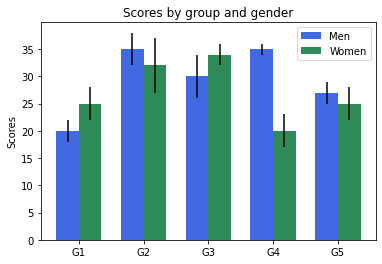

In [253]:
N = 5
menMeans = (20, 35, 30, 35, 27)
menStd =   (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, menMeans, width, color='royalblue', yerr=menStd)

womenMeans = (25, 32, 34, 20, 25)
womenStd =   (3, 5, 2, 3, 3)
rects2 = ax.bar(ind+width, womenMeans, width, color='seagreen', yerr=womenStd)

# add some
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('G1', 'G2', 'G3', 'G4', 'G5') )

ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )



In [227]:
unique_yearsgom

array([1976., 1977., 1978., 1979., 1981., 1982., 1983., 1984., 1985.,
       1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.])